In [1]:
! pip install -r requirements.txt

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached astral-3.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached auto_mix_prep-0.2.0-py3-none-any.whl
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
import csv
from collections import defaultdict
import datetime
import pytz
from astral import LocationInfo
from astral.sun import sun
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

In [56]:
path =  "./data"
relPathApart =  f"{path}/apartment"
relPathWeather = f"{path}/apartment-weather"
year = 2016
aptNum = 114
startDate = '2016-02-01' # '2016-02-01'
endDate = '2016-10-31' # '2016-03-03'
granularity = "1h"
randomState = 2024
numSelFeat = 11

In [57]:
! mkdir -p "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-electrical.tar.gz" -P "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-weather.tar.gz" -P "./data"

File ‘./data/apartment-electrical.tar.gz’ already there; not retrieving.

File ‘./data/apartment-weather.tar.gz’ already there; not retrieving.



In [58]:
! tar -xf "./data/apartment-electrical.tar.gz" -C "./data"
! tar -xf "./data/apartment-weather.tar.gz" -C "./data"

In [59]:
apartDfs = []
allFiles = glob.glob(f"{relPathApart}/{year}/*.csv")
for fileName in allFiles:
  df = pd.read_csv(fileName, parse_dates=[1], header=None, names=['date', 'power'])
  df["power"] = df["power"].astype(float)
  apartDfs.append(df)

print(apartDfs)

[                       date     power
0       2016-01-01 00:00:00  1.504383
1       2016-01-01 00:01:00  1.505133
2       2016-01-01 00:02:00  1.489983
3       2016-01-01 00:03:00  1.487867
4       2016-01-01 00:04:00  1.492550
...                     ...       ...
522610  2016-12-28 22:10:00  0.653800
522611  2016-12-28 22:11:00  0.654717
522612  2016-12-28 22:12:00  0.655417
522613  2016-12-28 22:13:00  0.655700
522614  2016-12-28 22:14:00  0.655083

[522615 rows x 2 columns],                        date     power
0       2016-01-01 00:00:00  0.515700
1       2016-01-01 00:01:00  1.291667
2       2016-01-01 00:02:00  2.297633
3       2016-01-01 00:03:00  2.298883
4       2016-01-01 00:04:00  2.296400
...                     ...       ...
503785  2016-12-15 20:25:00  9.448017
503786  2016-12-15 20:26:00  9.449933
503787  2016-12-15 20:27:00  9.393133
503788  2016-12-15 20:28:00  8.602283
503789  2016-12-15 20:29:00  6.881683

[503790 rows x 2 columns],                        date    

In [60]:
for i in range(len(apartDfs)):
  apartDfs[i] = apartDfs[i].loc[(apartDfs[i]['date'] > startDate) & (apartDfs[i]['date'] < endDate)]
  assert(len(apartDfs[i]) == len(apartDfs[0]))

                          date         power
0    2016-02-01 00:00:00-05:00  10360.396733
1    2016-02-01 01:00:00-05:00   9570.685767
2    2016-02-01 02:00:00-05:00   9363.859150
3    2016-02-01 03:00:00-05:00   9356.058217
4    2016-02-01 04:00:00-05:00   9172.311817
...                        ...           ...
6546 2016-10-30 19:00:00-04:00   6310.585633
6547 2016-10-30 20:00:00-04:00   5928.231200
6548 2016-10-30 21:00:00-04:00   6097.605117
6549 2016-10-30 22:00:00-04:00   6390.555850
6550 2016-10-30 23:00:00-04:00   5979.458733

[6551 rows x 2 columns]


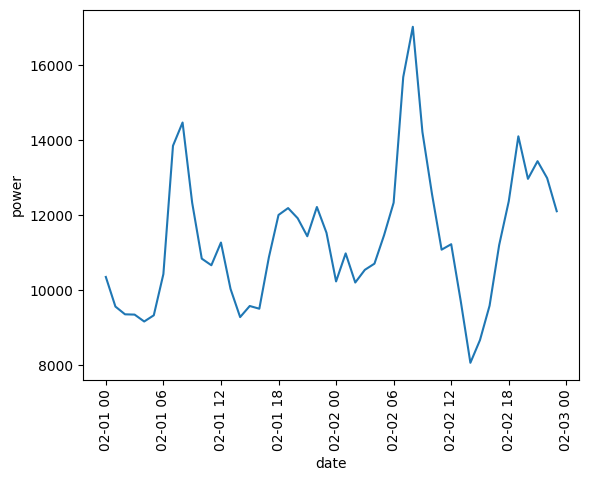

In [61]:
# Aggregate data of all the apartment
powerDf = pd.concat(apartDfs).groupby("date").sum().reset_index()
powerDf["date"] = pd.to_datetime(powerDf["date"]).dt.tz_localize(pytz.timezone('US/Eastern'))

# Perform granularity modification
powerDf = powerDf.resample(granularity, on="date").sum().reset_index()
powPlot = sns.lineplot(data=powerDf[powerDf["date"] < '2016-02-03'], x="date", y="power")
powPlot.set_xticklabels(powPlot.get_xticklabels(), rotation=90)
print(powerDf)

In [62]:
# Include weather data
def dateparse (time_in_secs):
    # Set the correct timezone
    dateTime = datetime.datetime.fromtimestamp(float(time_in_secs), tz=pytz.timezone('US/Eastern'))    
    return dateTime

print(pytz.timezone('US/Eastern'))
filePath = f"{relPathWeather}/apartment{year}.csv"
weathDf = pd.read_csv(filePath, parse_dates=["time"], date_parser=dateparse)
weathDf = weathDf.drop(columns=["icon", "cloudCover"])


print(weathDf)

US/Eastern


      temperature  humidity  visibility        summary  apparentTemperature  \
0           36.00      0.63       10.00          Clear                29.75   
1           35.73      0.62       10.00  Mostly Cloudy                29.39   
2           35.35      0.62       10.00          Clear                29.21   
3           35.19      0.63       10.00          Clear                30.21   
4           35.33      0.63       10.00          Clear                29.40   
...           ...       ...         ...            ...                  ...   
8779        29.62      0.71       10.00          Clear                24.18   
8780        26.61      0.78       10.00          Clear                26.61   
8781        24.42      0.82       10.00          Clear                18.56   
8782        23.20      0.85        9.89          Clear                23.20   
8783        22.50      0.87        9.23          Clear                22.50   

      pressure  windSpeed                      time

In [63]:
# Perform a join using the "nearest" datetime instead of the exactly matching one
powerWeathDf = pd.merge_asof(powerDf, weathDf, left_on="date", right_on="time", direction="nearest")
powerWeathDf.drop(columns=["time"], inplace=True)

print(powerWeathDf)

                          date         power  temperature  humidity  \
0    2016-02-01 00:00:00-05:00  10360.396733        39.49      0.71   
1    2016-02-01 01:00:00-05:00   9570.685767        38.19      0.76   
2    2016-02-01 02:00:00-05:00   9363.859150        38.94      0.77   
3    2016-02-01 03:00:00-05:00   9356.058217        38.26      0.80   
4    2016-02-01 04:00:00-05:00   9172.311817        38.16      0.81   
...                        ...           ...          ...       ...   
6546 2016-10-30 19:00:00-04:00   6310.585633        51.11      0.91   
6547 2016-10-30 20:00:00-04:00   5928.231200        50.17      0.93   
6548 2016-10-30 21:00:00-04:00   6097.605117        49.27      0.91   
6549 2016-10-30 22:00:00-04:00   6390.555850        48.18      0.90   
6550 2016-10-30 23:00:00-04:00   5979.458733        46.63      0.88   

      visibility     summary  apparentTemperature  pressure  windSpeed  \
0          10.00       Clear                34.94   1007.92       6.32   

In [64]:
# Add calendar information (day of the week, day of the month, hour of the day, period of the day (night time of daytime) and is weekend (boolean))
def dotwFromDatetime(date: datetime.datetime):
    return date.weekday()

def dotmFromDatetime(date: datetime.datetime):
    return date.day

def hotdFromDatetime(date: datetime.datetime):
    return date.hour

def potdFromDatetime(date: datetime.datetime):
    city = LocationInfo("Amherst", "USA")
    s = sun(city.observer, date=date.date())
    sunrise = s['sunrise']
    sunset = s['sunset']

    return "day" if sunrise <= date <= sunset else "night"

def isWeFromDatetime(date: datetime.datetime):
    # Saturday and Sunday are respectively 5 and 6
    return False if date.weekday() < 5 else True

powerWeathDf['dayOfWeek'] = powerWeathDf['date'].apply(dotwFromDatetime)
powerWeathDf['dayOfMonth'] = powerWeathDf['date'].apply(dotmFromDatetime)
powerWeathDf['hourOfDay'] = powerWeathDf['date'].apply(hotdFromDatetime)
powerWeathDf['periodOfDay'] = powerWeathDf['date'].apply(potdFromDatetime)
powerWeathDf['isWeekend'] = powerWeathDf['date'].apply(isWeFromDatetime)

<Axes: >

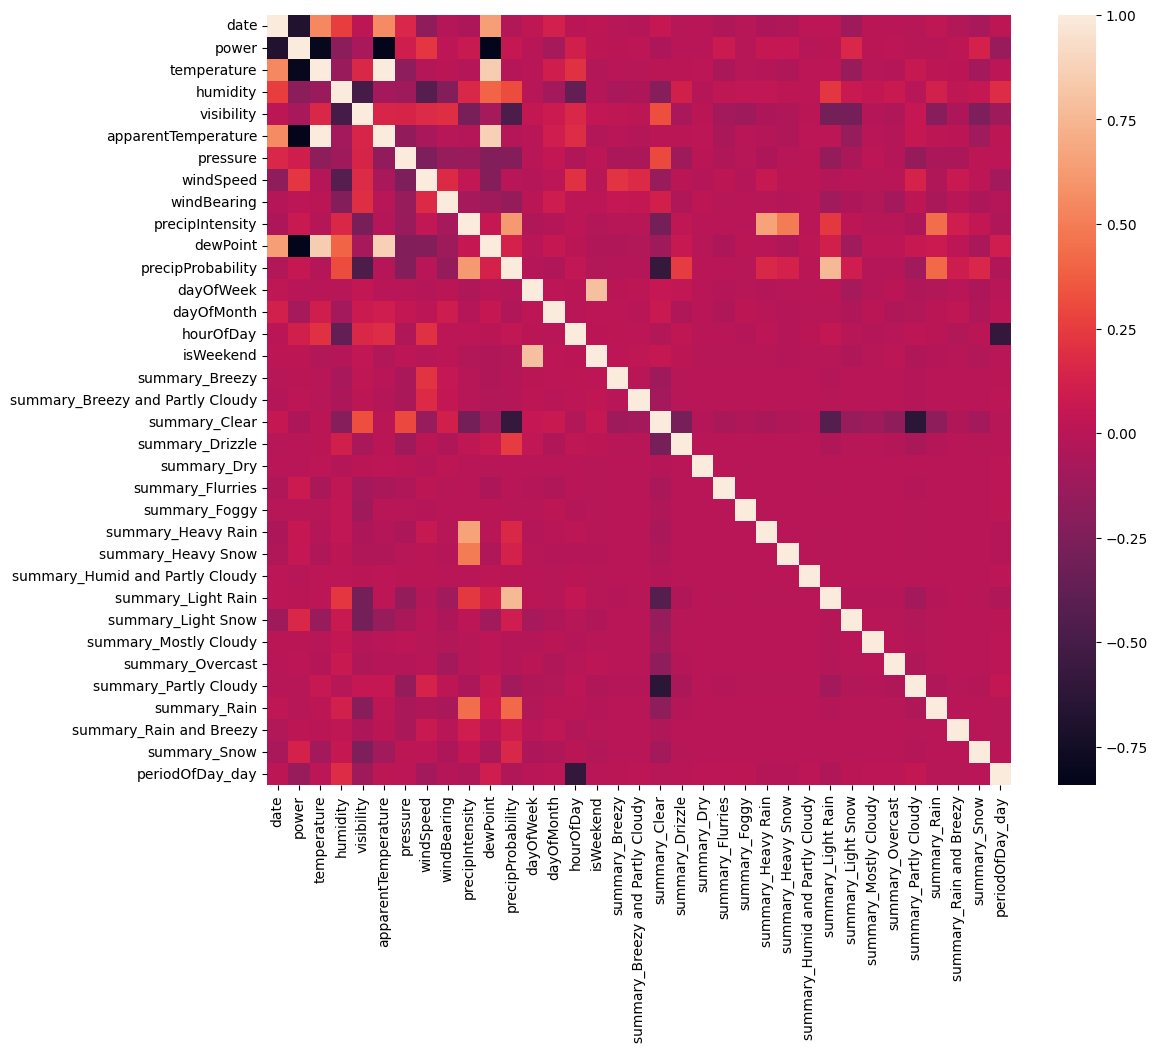

In [65]:
# Encode the categorical columns of the df
powerWeathEncDf = pd.get_dummies(powerWeathDf)
powerWeathEncDf = powerWeathEncDf.drop(columns=["periodOfDay_night"])

# Plot correlation matrix heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(powerWeathEncDf.corr())

In [66]:
# TODO Perform Recursive Feature Elimination with Random Forest as backend model
minFeat = 1
clf = RandomForestRegressor()
cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    scoring="explained_variance",
    cv=cv,
    verbose=True,
    min_features_to_select=minFeat,
    n_jobs=8,
)

X = powerWeathEncDf.drop(columns=["date", "power"])
Y = powerWeathEncDf["power"]

rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 fe

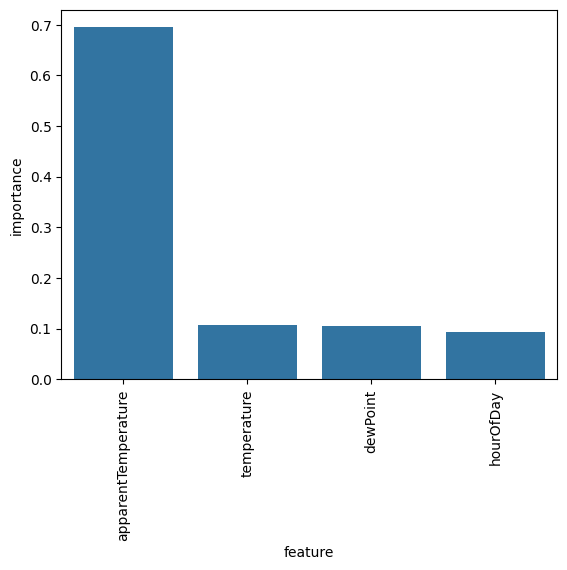

Text(0.5, 0, 'Number of features')

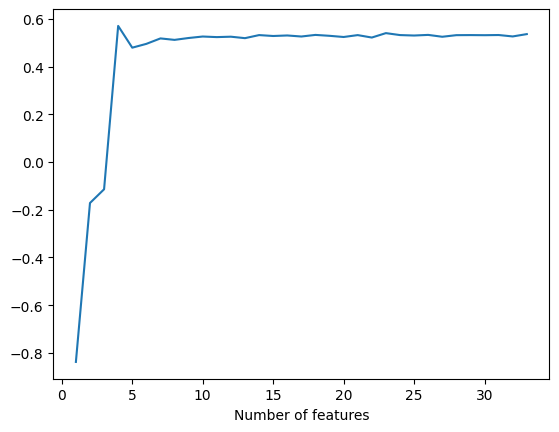

In [67]:
selFeat = pd.DataFrame(columns=["feature", "importance"])
i = 0
for selFeatIdx, col in zip(rfecv.support_, X.columns):
    if selFeatIdx:
        selFeat.loc[len(selFeat)] = {"feature": col, "importance": rfecv.estimator_.feature_importances_[i]}
        i += 1

selFeat.sort_values(by="importance", inplace=True, ascending=False)
selFeat.reset_index(inplace=True)


barPlot = sns.barplot(data=selFeat, x="feature", y="importance")
barPlot.set_xticklabels(barPlot.get_xticklabels(), rotation=90)
plt.show()

testScores = rfecv.cv_results_["mean_test_score"]
scoresPlot = sns.lineplot(x=rfecv.cv_results_["n_features"], y=testScores)
scoresPlot.set_xlabel("Number of features")

In [68]:
arrSelFeat = np.array(selFeat["feature"][range(numSelFeat)])
arrSelFeat = np.concatenate([["date"], ["power"], arrSelFeat])
powerWeathEncDf[arrSelFeat].to_csv(f"{path}/train.csv", index=False)

KeyError: '[4, 5, 6, 7, 8, 9, 10] not in index'

: 